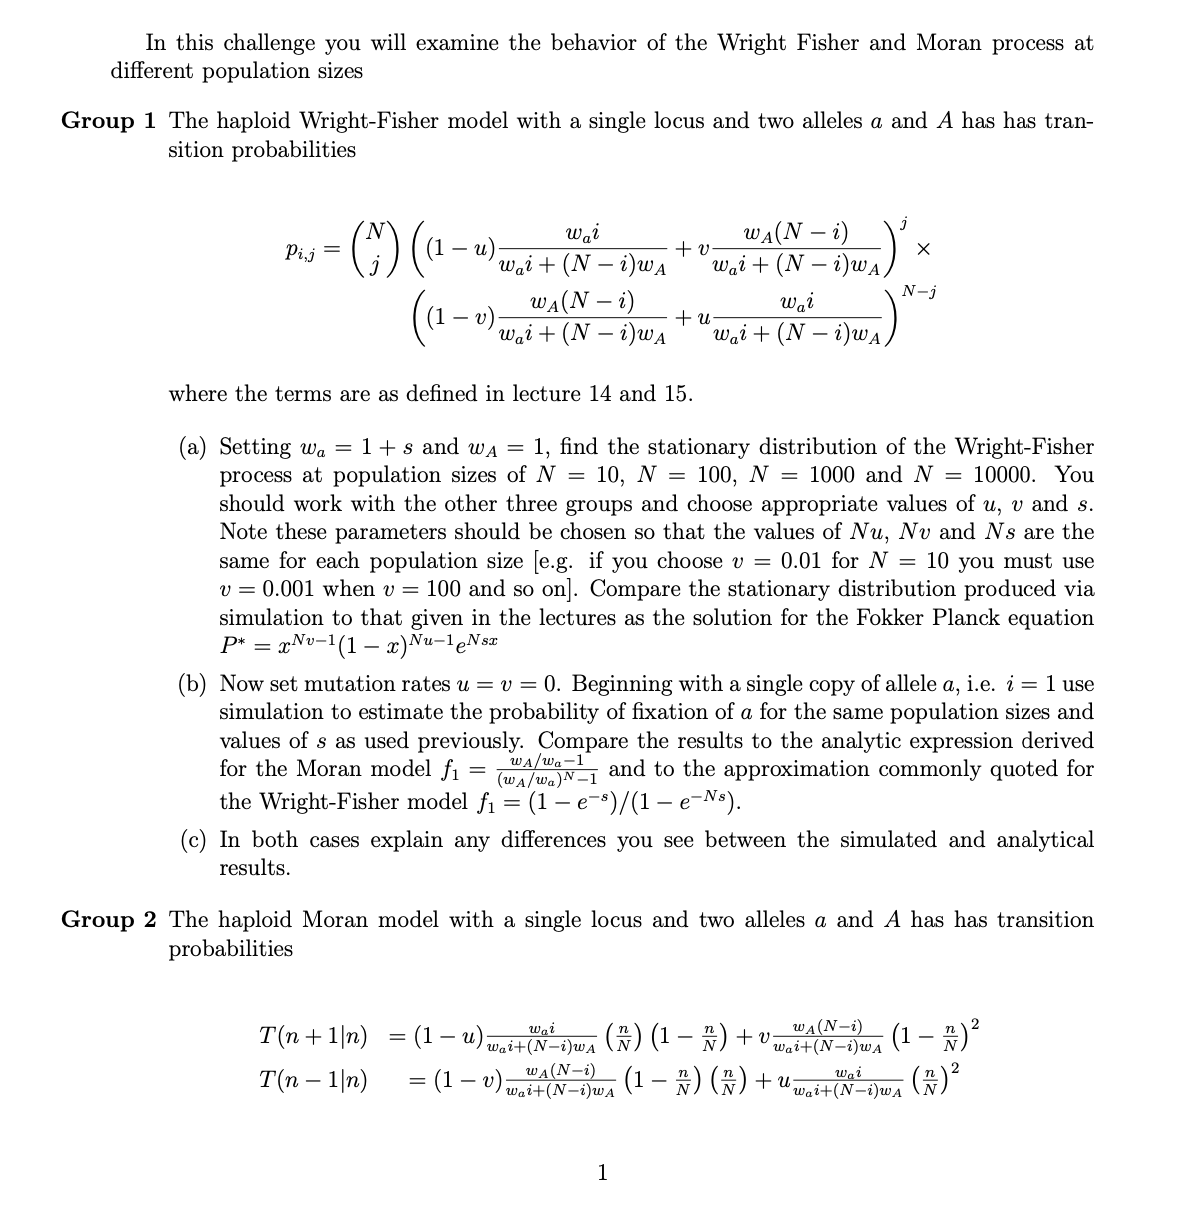

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import seaborn as sns
from numba import jit
import time
plt.style.use('ggplot')

In [16]:
@jit
def FokkerPlanck(x, N, u, v, s):
    return np.power(x, N*v - 1)*np.power((1 - x), (N*u - 1))*np.exp(N*s*x)

@jit
def FokkerPlanckMean(x, N, u, v, s):
    return x*np.power(x, N*v - 1)*np.power((1 - x), (N*u - 1))*np.exp(N*s*x)

@jit
def FixationProbMoran(N, w_a, w_A):
    return ((w_A/w_a) - 1)/(np.power(w_A/w_a, N) - 1)

@jit
def FixationProbFisher(N, s):
    return (1 - np.exp(-s))/(1 - np.exp(-N*s))


In [17]:
@jit
def MoranProcess(N, w_a, w_A, u, v, num_a, num_A, max_steps, dt, num_sim):
    step = 0
    a_counts = []
    while step < max_steps:
        prob_birth = ((w_a * num_a)*(1 - u) / (w_a * num_a + w_A * num_A) 
                      + (num_A * v) / (w_a * num_a + w_A * num_A)) * num_A / N
        prob_death = ((num_A)*(1 - v) / (w_a * num_a + w_A * num_A) 
                      + (w_a * num_a)*(u) / (w_a * num_a + w_A * num_A)) * num_a / N
        r = np.random.rand(1)
        if r <= prob_birth*dt:
            num_a += 1
            num_A -= 1
        elif r <= (prob_birth + prob_death)*dt:
            num_a -= 1
            num_A += 1
        step += 1    
        a_counts.append(num_a)
    return a_counts[-1]


In [18]:
start = time.time()

population_sizes = [10, 100, 1000]
mutation_rates = [0.2, 0.02, 0.002]
s_list = [0.2, 0.02, 0.002]
w_A = 1
max_steps = 500000
dt = 1
num_sims = 1000
frequency = []
Fokker_Planck = []

for i in range(len(population_sizes)):
    x = np.linspace(0, 1, population_sizes[i])
    P = FokkerPlanck(x, population_sizes[i], mutation_rates[i], mutation_rates[i], s_list[i])
    print("Population Size: ", population_sizes[i])
    simulations = [MoranProcess(population_sizes[i], 1+s_list[i], w_A, mutation_rates[i], mutation_rates[i], 
                                 population_sizes[i]//2, population_sizes[i] - (population_sizes[i]//2),
                                 max_steps, dt, j) for j in range(num_sims)]
    Fokker_Planck.append(P)
    a_counts = np.asarray(simulations)
    frequency.append(a_counts)
    
end = time.time()
print('total running time = %1.2f' %(end-start), 'sec') 

Population Size:  10
Population Size:  100
Population Size:  1000
total running time = 707.08 sec


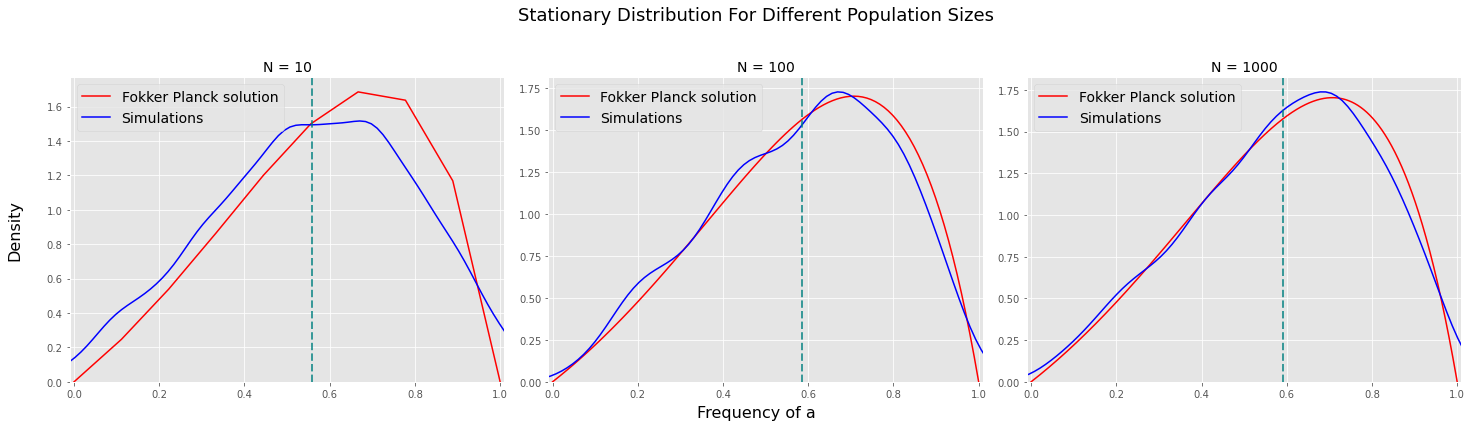

In [20]:
fig, ax = plt.subplots(1,len(population_sizes), figsize=(20,5))
fig.suptitle('Stationary Distribution For Different Population Sizes', fontsize=18, y=1.12)
fig.text(0.5, -0.02, 'Frequency of a', ha='center', fontsize=16)
fig.text(-0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)
for i in range(len(population_sizes)):
    x = np.linspace(0, 1, population_sizes[i])
    data = frequency[i]/population_sizes[i]
    FP = Fokker_Planck[i]
    ax[i].plot(x, 2*FP, label='1', color='r')
    sns.kdeplot(data, ax=ax[i], label='2', color='b')
    ax[i].axvline(np.mean(data), color='teal', linestyle='dashed', linewidth=2, alpha=0.75)
    ax[i].legend(['Fokker Planck solution', 'Simulations'], fontsize=14)
    ax[i].set_title('N = {0}'.format(population_sizes[i]), fontsize=14)
    ax[i].set_xlim([-0.01,1.01])
    plt.tight_layout()

In [7]:
start = time.time()

population_sizes = [10, 100, 1000, 10000]
mutation_rates = [0.01, 0.001, 0.0001, 0.00001]
s_list = [0.2, 0.02, 0.002, 0.0002]
w_A = 1
max_steps = 500000
dt = 1
num_sims = 1000
frequency = []
Fokker_Planck = []

for i in range(len(population_sizes)):
    x = np.linspace(0, 1, population_sizes[i])
    P = FokkerPlanck(x, population_sizes[i], mutation_rates[i], mutation_rates[i], s_list[i])
    print("Population Size: ", population_sizes[i])
    simulations = [MoranProcess(population_sizes[i], 1+s_list[i], w_A, mutation_rates[i], mutation_rates[i], 
                                 population_sizes[i]//2, population_sizes[i] - (population_sizes[i]//2),
                                 max_steps, dt, j) for j in range(num_sims)]
    Fokker_Planck.append(P)
    a_counts = np.asarray(simulations)
    frequency.append(a_counts)
    
end = time.time()
print('total running time = %1.2f' %(end-start), 'sec') 

Population Size:  10
Population Size:  100
Population Size:  1000
Population Size:  10000
total running time = 1003.26 sec


Difference in mean =0.28
Difference in mean =0.27
Difference in mean =0.11


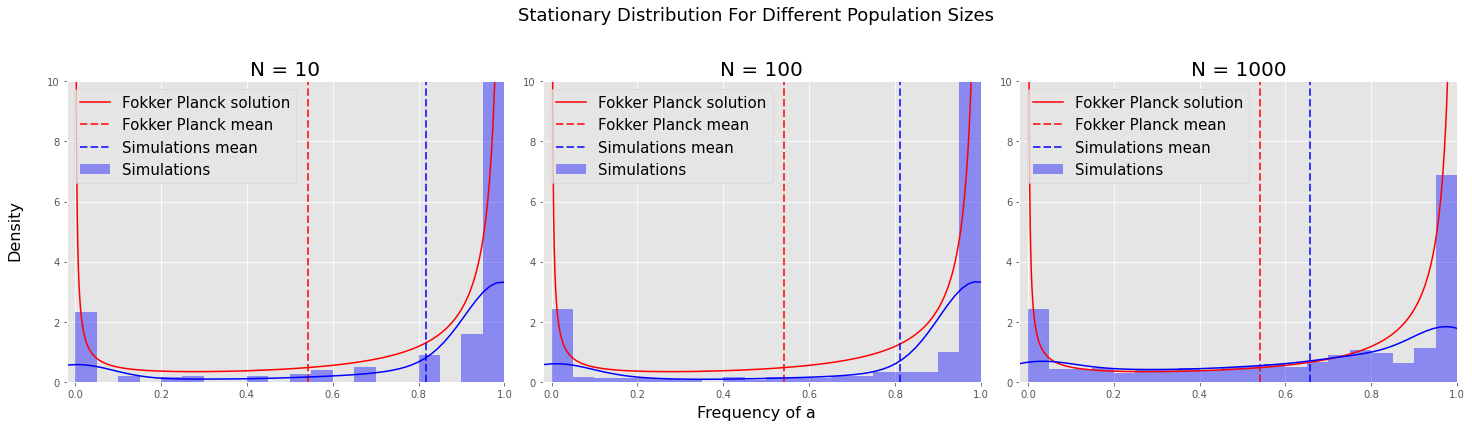

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Stationary Distribution For Different Population Sizes', fontsize=18, y=1.12)
fig.text(0.5, -0.02, 'Frequency of a', ha='center', fontsize=16)
fig.text(-0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)

x = np.linspace(0, 1, population_sizes[-1])
integral = quad(FokkerPlanck, 0, 1, args=(1, 0.1, 0.1, 0.2))
first_moment = quad(FokkerPlanckMean, 0, 1, args=(1, 0.1, 0.1, 0.2))
analytic_mean = first_moment[0]/integral[0]
FP_density = Fokker_Planck[-1]/integral[0]

for i in range(len(population_sizes)-1):
    data = frequency[i]/population_sizes[i]
    print('Difference in mean =%1.2f' %(np.mean(data)-analytic_mean))
    ax[i].plot(x, FP_density, label='1', color='r')
    ax[i].axvline(x=analytic_mean, label='2', color='r', linestyle='dashed', linewidth=2, alpha=0.75  )
    sns.distplot(data, ax=ax[i], bins=20, label='3', color='b')
    ax[i].axvline(np.mean(data), label='4', color='b', linestyle='dashed', linewidth=2, alpha=0.75)
    ax[i].legend(['Fokker Planck solution','Fokker Planck mean','Simulations mean','Simulations'],fontsize=15,\
                 loc='upper left')
    ax[i].set_title('N = {0}'.format(population_sizes[i]), fontsize=20)
    ax[i].set_xlim([-0.02,1])
    ax[i].set_ylim([0,10])
    plt.tight_layout()

The plots illustrate how the Fokker-Planck approximation becomes more accurate as $N$ becomes larger. For a better comparison look at the difference in the mean of simulations ( the exact mean ) and the mean obtained by Fokker-Plank distribution. The difference becomes smaller as $N\rightarrow \infty$.

In [5]:
start = time.time()

population_sizes = [10, 100, 1000, 10000]
mutation_rate = 0
s_list = [0.2, 0.02, 0.002, 0.0002]
w_A = 1
max_steps = 500000
dt = 1
num_sims = 1000
fix_prob_sim = []
fix_prob_Moran = []
fix_prob_wf = []

for i in range(len(population_sizes)):
    print("Population Size: ", population_sizes[i])
    f_M = FixationProbMoran(population_sizes[i], 1+s_list[i], w_A)
    f_WF = FixationProbFisher(population_sizes[i], s_list[i])
    simulations = [MoranProcess(population_sizes[i], 1+s_list[i], w_A, mutation_rate, mutation_rate, 
                                 1, population_sizes[i] - 1,
                                 max_steps, dt, j) for j in range(num_sims)]
    fix_prob = simulations.count(population_sizes[i])/num_sims
    fix_prob_sim.append(fix_prob)
    fix_prob_Moran.append(f_M)
    fix_prob_wf.append(f_WF)
      
end = time.time()
print('total running time = %1.2f' %(end-start), 'sec') 

Population Size:  10
Population Size:  100
Population Size:  1000
Population Size:  10000
total running time = 987.10 sec


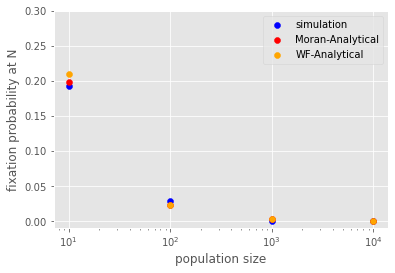

In [8]:
plt.scatter(population_sizes, fix_prob_sim, color='b', label='simulation')
plt.scatter(population_sizes, fix_prob_Moran, color='r', label='Moran-Analytical')
plt.scatter(population_sizes, fix_prob_wf, color='orange', label='WF-Analytical')
plt.xscale('Log')
plt.xlabel('population size')
plt.ylabel('fixation probability at N')
plt.ylim([-0.01,0.3])
plt.legend()
plt.show()

In the above plot the $x$ scale is log. As we see from the plot, the fixation probability approximation, $\frac{(w_A/w_a) - 1}{(w_A/w_a)^{N} - 1}$, becomes more accurate as $N\rightarrow \infty$.